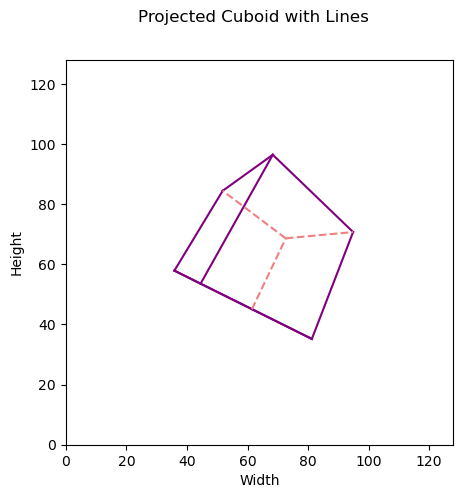

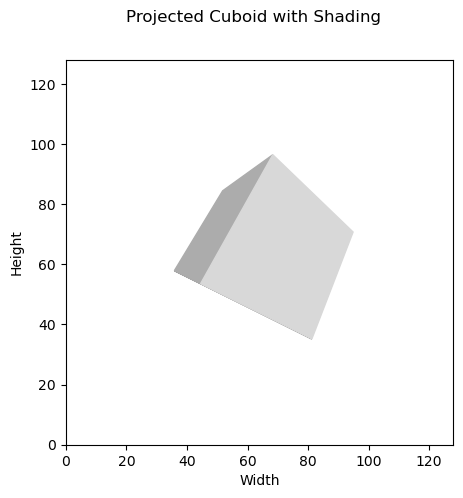

In [3]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from IPython.display import HTML
from matplotlib import animation
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
import cv2

H, W = 128, 128

# 创建了立方体
def get_cube(center=(0, 0, 2), rotation_angles=[0., 0., 0.], with_normals=False, scale=1.):
    ''' Returns an array containing the faces of a cube.

    Args:
    center (tuple): center of the cube
    rotation_angles (tuple): Euler angles describing the rotation of the cube
    with_normals (bool): whether to return the normal vectors of the faces
    scale (float): scale of cube

    '''
    # A cube consists of 6 faces and 8 corners:
    #   +----+
    #  /    /|
    # +----+ |
    # |    | +
    # |    |/
    # +----+
    # Let's first consider the unit cube. The corners are:
    corners = np.array([(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)])
    # Let's now center the cube at (0, 0, 0)
    corners = corners - np.array([0.5, 0.5, 0.5], dtype=np.float32).reshape(1, 3)
    # Let's scale the cube
    corners = corners * scale
    # And we rotate the cube wrt. the input rotation angles
    rot_mat = R.from_euler('xyz', rotation_angles, degrees=True).as_matrix()
    corners = np.matmul(corners, rot_mat.T)
    # Finally, we shift the cube according to the input center tuple
    corners = corners + np.array(center, dtype=np.float32).reshape(1, 3)

    # The 6 faces of the cube are then given as:
    faces = np.array([
    # all faces containing (0, 0, 0)
    [corners[0], corners[1], corners[3], corners[2]],
    [corners[0], corners[1], corners[5], corners[4]],
    [corners[0], corners[2], corners[6], corners[4]],
    # all faces containing (1, 1, 1)
    [corners[-1], corners[-2], corners[-4], corners[-3]],
    [corners[-1], corners[-2], corners[-6], corners[-5]],
    [corners[-1], corners[-3], corners[-7], corners[-5]],
    ])

    if with_normals:
        normals = np.array([(-1, 0, 0), (0, -1, 0), (0, 0, -1), (1, 0, 0), (0, 1, 0), (0, 0, 1)])
        normals = np.matmul(normals, rot_mat.T)
        return faces, normals
    else:
        return faces
    
# 确定相机参数
def get_camera_intrinsics(fx=70, fy=70, cx=W/2., cy=H/2.):
    ''' Returns the camera intrinsics matrix.

    Hint: The array should be of size 3x3 and of dtype float32 (see the assertion below)

    Args:
    fx (float): focal length in x-direction f_x
    fy (float): focal length in y-direction f_y
    cx (float): x component of the principal point
    cy (float): y compontent of th principal point
    '''
    
    # Insert your code here
    K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]], dtype=np.float32)
    
    assert(K.shape == (3, 3) and K.dtype == np.float32)
    return K

# 对单个点进行投影
def get_perspective_projection(x_c, K):
    ''' Projects the 3D point x_c to screen space and returns the 2D pixel coordinates.
    
    Args:
        x_c (array): 3D point in camera space
        K (array): camera intrinsics matrix (3x3)
    '''
    assert(x_c.shape == (3,) and K.shape == (3, 3))

    # Insert your code here
    x = np.matmul(K, x_c)
    x_s = x[:2] / x[2]
    
    assert(x_s.shape == (2,))
    return x_s

# 对整个立方体进行投影
def project_cube(cube, K):
    ''' Projects the cube.
    
    Args:
        cube (array): cube
        K (array): camera intrinsics matrix
    '''
    s = cube.shape
    assert(s[-1] == 3)
    cube = cube.reshape(-1, 3)
    projected_cube = np.stack([get_perspective_projection(p, K) for p in cube])
    projected_cube = projected_cube.reshape(*s[:-1], 2)
    return projected_cube

# 提取立方体边线
def get_cube_edges(faces):
    ''' Returns an array containing the edges of a cube, grouped by faces.

    Args:
    faces (array): array containing the faces of the cube

    Returns:
    edges (array): array containing the edges of the cube, grouped by faces
    '''
    edges = []
    for face in faces:
        face_edges = []
        for i in range(4):
            edge = np.array([face[i], face[(i + 1) % 4]])
            face_edges.append(edge)
        edges.append(face_edges)
    return np.array(edges)

# 对各个面生成光影颜色
def get_face_color(normal, point_light_direction=(0, 0, 1)):
    ''' Returns the face color for input normal.
    
    Args:
        normal (array): 3D normal vector
        point_light_direction (tuple): 3D point light direction vector
    '''
    assert(normal.shape == (3,))
    point_light_direction = np.array(point_light_direction, dtype=np.float32)

    light_intensity = np.dot(normal, -point_light_direction)
    
    color_intensity = 0.1 + (light_intensity * 0.5 + 0.5) * 0.8
    color = np.stack([color_intensity for i in range(3)])
    return color

# 对所有面生成光影颜色
def get_face_colors(normals, light_direction=(0, 0, 1)):
    ''' Returns the face colors for given normals and viewing direction.

    Args:
    normals (array): face normals (last dimension is 3)
    light_direction (tuple): light direction vector
    '''
    colors = np.stack([get_face_color(normal, light_direction) for normal in normals])
    return colors

# 绘制立方体的轮廓
def plot_projected_cube_outlines(projected_cube, edges, figsize=(5, 5), figtitle=None, face_mask=None):
    ''' Plots the projected cube.

    Args:
    projected_cube (array): projected cube (size 6x4x2)
    figsize (tuple): size of the figure
    colors (list): list of colors for polygons. If None, 'blue' is used for all faces
    face_mask (array): mask for individual faces of the cube. If None, all faces are drawn.
    '''
    assert(projected_cube.shape == (6, 4, 2))
    assert(edges.shape == (6, 4, 2, 2))
    fig, ax = plt.subplots(figsize=figsize)
    if figtitle is not None:
        fig.suptitle(figtitle)
    if face_mask is None:
        face_mask = [True for i in range(len(projected_cube))]
    ax.set_xlim(0, W), ax.set_ylim(0, H)
    ax.set_xlabel('Width'), ax.set_ylabel("Height")

    drawn_edges = set()

    for face_edges, mask in zip(edges, face_mask):
        if mask:
            for edge in face_edges:
                # 标准化顶点顺序：按坐标排序顶点元组，确保边唯一性
                p1, p2 = tuple(edge[0]), tuple(edge[1])
                sorted_edge = tuple(sorted([p1, p2]))  # 关键排序操作！
                if sorted_edge not in drawn_edges:
                    line = Line2D(edge[:,0], edge[:,1], color='purple')
                    ax.add_line(line)
                    drawn_edges.add(sorted_edge)
    for face_edges, mask in zip(edges, face_mask):
        if not mask:
            for edge in face_edges:
                p1, p2 = tuple(edge[0]), tuple(edge[1])
                sorted_edge = tuple(sorted([p1, p2]))
                if sorted_edge not in drawn_edges:
                    line = Line2D(edge[:,0], edge[:,1], color='lightcoral', linestyle='--')
                    ax.add_line(line)
                    drawn_edges.add(sorted_edge)

    plt.show()

# 绘制立方体的光影
def plot_projected_cube(projected_cube, figsize=(5, 5), figtitle=None, colors=None, face_mask=None):
    ''' Plots the projected cube.

    Args:
    projected_cube (array): projected cube (size 6x4x2)
    figsize (tuple): size of the figure
    colors (list): list of colors for polygons. If None, 'blue' is used for all faces
    face_mask (array): mask for individual faces of the cube. If None, all faces are drawn.
    '''
    assert(projected_cube.shape == (6, 4, 2))
    fig, ax = plt.subplots(figsize=figsize)
    if figtitle is not None:
        fig.suptitle(figtitle)
    if colors is None:
        colors = ['C0' for i in range(len(projected_cube))]
    if face_mask is None:
        face_mask = [True for i in range(len(projected_cube))]
    ax.set_xlim(0, W), ax.set_ylim(0, H)
    ax.set_xlabel('Width'), ax.set_ylabel("Height")
    for (cube_face, c, mask) in zip(projected_cube, colors, face_mask):
        if mask:
            ax.add_patch(Polygon(cube_face, color=c))
    plt.show()

# 确定遮挡关系
def get_face_mask(cube, normals, camera_location=(0, 0, 0)):
    ''' Returns a mask for each face of the cube whether it is visible when projected.
    
    Args:
    cube (array): cube faces
    normals (array): face normals (last dimension is 3)
    camera_location (tuple): viewing camera location vector
    '''
    assert(cube.shape == (6, 4, 3) and normals.shape[-1] == 3)
    camera_location = np.array(camera_location).reshape(1, 3) 

    face_center = np.mean(cube, axis=1)
    viewing_direction = camera_location - face_center
    dot_product = np.sum(normals * viewing_direction, axis=-1)
    mask = dot_product > 0.0
    return mask


faces, normals = get_cube(rotation_angles=[30, 60,0], with_normals=True)
colors = get_face_colors(normals)
mask = get_face_mask(faces, normals)
projected_cube = project_cube(faces, get_camera_intrinsics())
edges = get_cube_edges(projected_cube)
plot_projected_cube_outlines(projected_cube, edges, figtitle="Projected Cuboid with Lines", face_mask=mask)
plot_projected_cube(projected_cube, figtitle="Projected Cuboid with Shading", colors=colors, face_mask=mask)


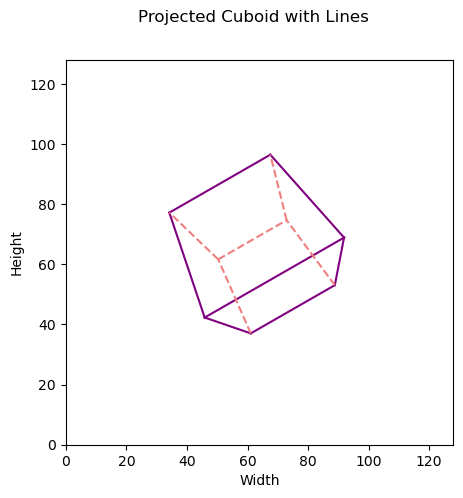

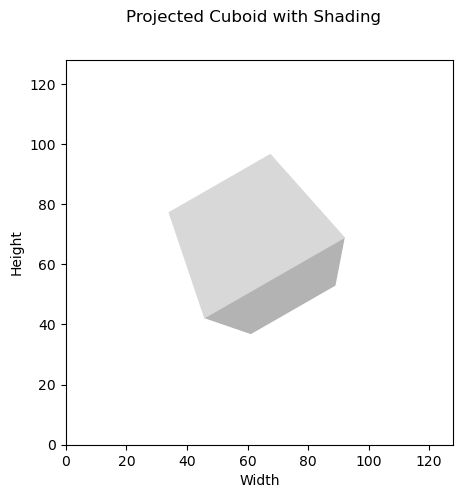

In [10]:
faces, normals = get_cube(rotation_angles=[30, 0,30], with_normals=True)
colors = get_face_colors(normals)
mask = get_face_mask(faces, normals)
projected_cube = project_cube(faces, get_camera_intrinsics())
edges = get_cube_edges(projected_cube)
plot_projected_cube_outlines(projected_cube, edges, figtitle="Projected Cuboid with Lines", face_mask=mask)
plot_projected_cube(projected_cube, figtitle="Projected Cuboid with Shading", colors=colors, face_mask=mask)


In [35]:
def get_outline_animation(K_list, cube_list, figsize=(5, 5), title=None):
    ''' Create a matplotlib animation for the list of camera matrices and cubes with face normals. '''
    assert len(K_list) == len(cube_list)

    cubes = [i[0] for i in cube_list]
    normals = [i[1] for i in cube_list]
    masks = [get_face_mask(cube_i, normals_i) for (cube_i, normals_i) in zip(cubes, normals)]

    projected_cubes = [project_cube(cube, Ki) for (cube, Ki) in zip(cubes, K_list)]
    edges_list = [get_cube_edges(pc) for pc in projected_cubes]

    # 计算所有帧中的最大边数
    max_edges = 0
    for edges in edges_list:
        unique_edges = set()
        for face in edges:
            for e in face:
                p1, p2 = tuple(e[0]), tuple(e[1])
                sorted_edge = tuple(sorted([p1, p2]))
                unique_edges.add(sorted_edge)
        max_edges = max(max_edges, len(unique_edges))

    # 创建新图形和坐标轴
    fig, ax = plt.subplots(figsize=figsize)
    plt.close(fig)
    if title is not None:
        fig.suptitle(title)
    ax.set_xlim(0, W)
    ax.set_ylim(0, H)
    
    lines = [Line2D([], [], visible=False) for _ in range(max_edges)]
    for line in lines:
        ax.add_line(line)

    def outline_animate(n):
        mask = masks[n]
        edges = edges_list[n]
        
        
        drawn_edges = set()
        line_idx = 0
        
        for face_edges, mask_flag in zip(edges, mask):
            if mask_flag:
                for edge in face_edges:
                    p1, p2 = tuple(edge[0]), tuple(edge[1])
                    sorted_edge = tuple(sorted([p1, p2]))
                    if sorted_edge not in drawn_edges and line_idx < len(lines):
                        lines[line_idx].set_data(edge[:,0], edge[:,1])
                        lines[line_idx].set_color('purple')
                        lines[line_idx].set_linestyle('-')
                        lines[line_idx].set_visible(True)
                        drawn_edges.add(sorted_edge)
                        line_idx += 1
        
        for face_edges, mask_flag in zip(edges, mask):
            if not mask_flag:
                for edge in face_edges:
                    p1, p2 = tuple(edge[0]), tuple(edge[1])
                    sorted_edge = tuple(sorted([p1, p2]))
                    if sorted_edge not in drawn_edges and line_idx < len(lines):
                        lines[line_idx].set_data(edge[:,0], edge[:,1])
                        lines[line_idx].set_color('lightcoral')
                        lines[line_idx].set_linestyle('--')
                        lines[line_idx].set_visible(True)
                        drawn_edges.add(sorted_edge)
                        line_idx += 1
        
        return lines

    anim = animation.FuncAnimation(fig, outline_animate, frames=len(K_list), interval=100, blit=True)
    return anim

In [31]:
#生成动画
def get_animation(K_list, cube_list, figsize=(5, 5), title=None):
    ''' Create a matplotlib animation for the list of camera matrices and cubes with face normals.

    Args:
    K_list (list): list of camera matrices
    cube_list (list): list of cubes
    figsize (tuple): matplotlib figsize
    title (str): if not None, the title of the figure
    '''
    assert(len(K_list) == len(cube_list))

    # split cube_list into cubes and normals
    cubes = [i[0] for i in cube_list]
    normals = [i[1] for i in cube_list]

    # get face colors and masks
    colors = [get_face_colors(normals_i) for normals_i in normals]
    masks = [get_face_mask(cube_i, normals_i) for (cube_i, normals_i) in zip(cubes, normals)]

    # get projected cubes
    projected_cubes = [project_cube(cube, Ki) for (cube, Ki) in zip(cubes, K_list)]

    # initialize plot
    uv = projected_cubes[0]
    patches = [Polygon(uv_i, closed=True, color='white') for uv_i in uv]


    def animate(n):
        ''' Animation function for matplotlib visualizations.
        '''
        uv = projected_cubes[n]
        color = colors[n]
        mask = masks[n]
        for patch, uv_i, color_i, mask_i in zip(patches, uv, color, mask):
            if mask_i:
                patch.set_xy(uv_i)
                patch.set_color(color_i)
            else:
                uv_i[:] = -80
                patch.set_color(color_i)
                patch.set_xy(uv_i)
        return patches

    fig, ax = plt.subplots(figsize=figsize)
    if title is not None:
        fig.suptitle(title)
    plt.close()
    ax.set_xlim(0, W)
    ax.set_ylim(0, H)
    for patch in patches:
        ax.add_patch(patch)
    anim = animation.FuncAnimation(fig, animate, frames=len(K_list), interval=100, blit=True)
    return anim


K_list = [get_camera_intrinsics() for i in range(30)]
cube_list = [get_cube(rotation_angles=[0, angle, angle], with_normals=True) for angle in np.linspace(0, 360, 30)]
anim = get_animation(K_list, cube_list, title="Rotation of Cube")
HTML(anim.to_html5_video())

In [37]:
outline_anim = get_outline_animation(K_list, cube_list, title="Rotation of the Cube Outline")
HTML(outline_anim.to_html5_video())